In [1]:
import soundfile as sf
import numpy as np
import scipy as signal
import matplotlib.pyplot as plt
import math
import pandas as pd
import itertools

Reference: [link](https://static1.squarespace.com/static/5554d97de4b0ee3b50a3ad52/t/5ad40423758d46ce6333e4e0/1523844131732/Steinmetz_IEEE_Student_Paper_Competition_2018.pdf)

In [5]:
# Load data
data1,samplerate = sf.read('/Users/yihanhu/Desktop/CSE4223/Data/multiple source/postfiltered_2020-08-19_11_40_03_2.raw', 
               channels=4, 
               samplerate=16000,
               subtype='PCM_16'
              )
data2,samplerate = sf.read('/Users/yihanhu/Desktop/CSE4223/Data/multiple source//postfiltered_2020-08-19_11_40_03_5.raw', 
               channels=4, 
               samplerate=16000,
               subtype='PCM_16'
              )

In [54]:
# Functions
def truncate(sig1, sig2):
    '''
    This function truncates the longer signal and return two signals of the same length
    '''
    l1, l2 = len(sig1), len(sig2)
    if l1 <= l2:
        return sig1, sig2[0:l1]
    else:
        return sig1[0:l2], sig2
    
def padding(sig1, sig2):
    '''
    This function pads the shorter sequence to the length of longer sequence with 0
    '''
    length = np.maximum(len(sig1), len(sig2))
    l1, l2 = len(sig1), len(sig2)
    if l1 < length:
        return np.concatenate((sig1, np.linspace(0,0,length - l1))), sig2
    if l2 < length:
        return sig1, np.concatenate((sig2, np.linspace(0,0,length - l2)))

def prepadding(sig1, sig2, winDuration, Fs):
    l = winDuration * Fs
    N = len(sig1)    
    # Padding to have an interger number of windows
    if N%l != 0:
        padWidth = l-N%l
        sig1 = np.pad(sig1, (0, padWidth), 'constant', constant_values = 0)
        sig2 = np.pad(sig2, (0, padWidth), 'constant', constant_values = 0)
        
    numOfWindows = len(sig1)/l
    
    return sig1, sig2, numOfWindows

def gcc_phat(sig1, sig2, fs=16000, window=True, windowName="hanning"):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method. In this modified
    function, sig1 and sig2 are garuanteed to have the same length
    '''
    n = sig1.shape[0]
    
    # Add window
    if window: 
        win = getattr(np, windowName)(n)
        sig1 = sig1 * win
        sig2 = sig2 * win

    # Generalized Cross Correlation Phase Transform
    SIG1 = np.fft.rfft(sig1, n=n)
    SIG2 = np.fft.rfft(sig2, n=n)
        
    psi = np.conj(SIG1)*SIG2/np.abs(np.conj(SIG1)*SIG2)
    
    gcc = np.fft.irfft(psi, n)

    shift = int(n / 2)

    gcc = np.concatenate((gcc[-shift:], gcc[:shift+1]))

    # find max cross correlation index
    delta = np.argmax(np.abs(gcc)) - shift

    tau = np.float(delta / float(fs))
    
    if(np.any(np.isnan(gcc))): 
        tau = math.nan
    
    return tau,gcc


def width_cc(cc, threshold=0.5):
    '''
    Calculate the width between the first sample and the last sample that are above the thresold.
    Threshold is precentage of the peak value
    '''
    cc_max = np.amax(cc)
    peak_index = np.where(cc == cc_max)
    mag_thr = threshold * cc_max
    width = 0
    for ii in range(len(cc)):
        if cc[ii] > mag_thr:
            width = width + 1
    return width

def significance(cc):
    '''
    Calculate the significance of each cross correlation sequence
    '''
    cc_mean = np.mean(cc)
    cc_std = np.std(cc)
    return (np.amax(cc) - cc_mean)/cc_std

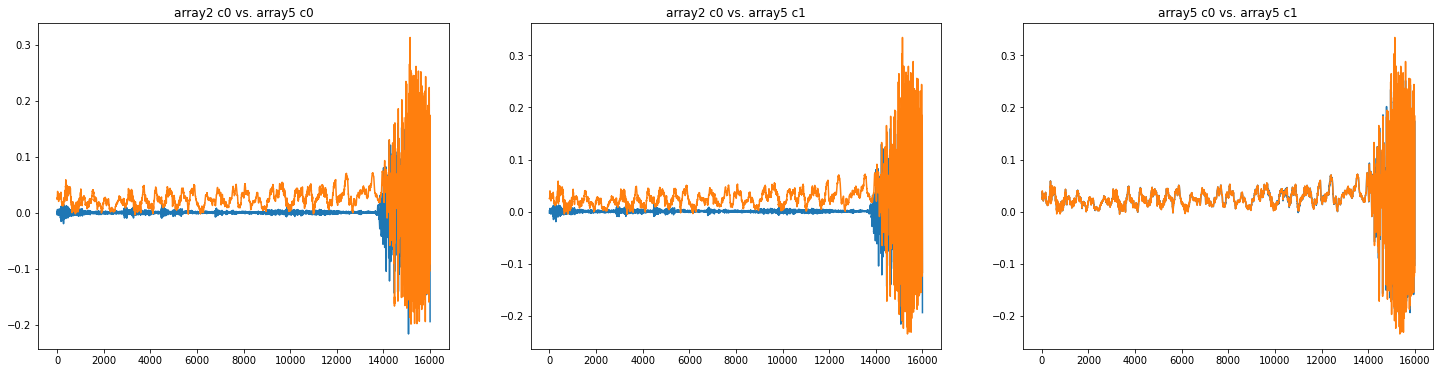

In [107]:
# 2: Start time: 2020-08-19 11:40:03.848074
# 5: Start time: 2020-08-19 11:40:03.878391
# 66s - 67s
t = 65
sig1 = data1[:,0] # array2 c0
sig2 = data2[:,0] # array5 c0
sig3 = data2[:,1] # array5 c1
fs = 16000
sig1Temp, sig2Temp, sig3Temp = sig1[t*fs:int((t+1)*fs)], sig2[t*fs:int((t+1)*fs)], sig3[t*fs:int((t+1)*fs)]
plt.figure(figsize = (25,6))
plt.subplot(131)
plt.plot(sig1Temp)
plt.plot(sig2Temp)
plt.title("array2 c0 vs. array5 c0")
plt.subplot(132)
plt.plot(sig1Temp)
plt.plot(sig3Temp)
plt.title("array2 c0 vs. array5 c1")
plt.subplot(133)
plt.plot(sig2Temp)
plt.plot(sig3Temp)
plt.title("array5 c0 vs. array5 c1")

plt.show()

Delay between array2 c0 and array5 c0 is 0.0115 s
Delay between array2 c0 and array5 c1 is 0.019125 s
Delay between array5 c0 and array5 c1 is -6.25e-05 s
Default delay is 0.0303 s


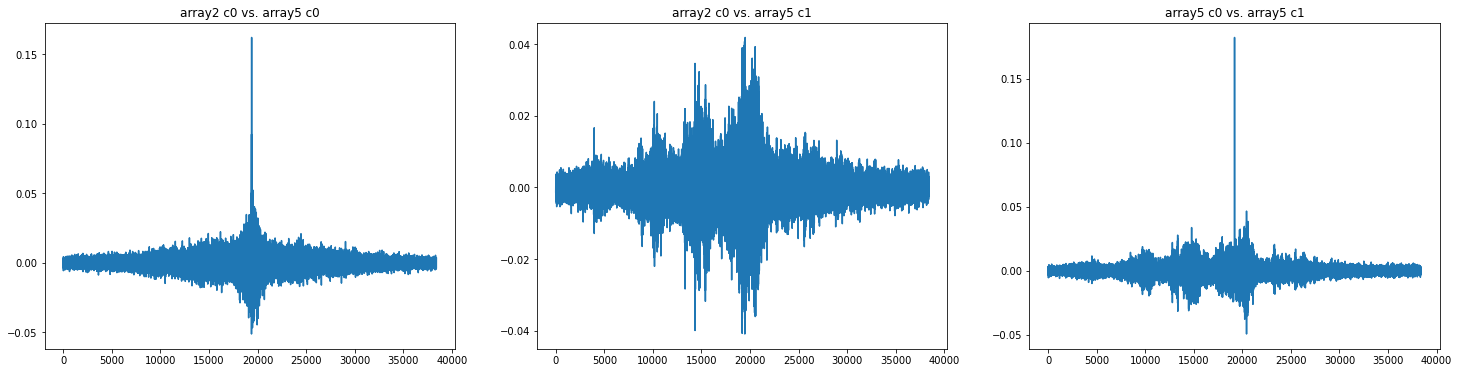

In [106]:
tau1, gcc1 = gcc_phat(sig1Temp, sig2Temp)
print("Delay between array2 c0 and array5 c0 is " + str(tau1) + " s")
tau2, gcc2 = gcc_phat(sig1Temp, sig3Temp)
print("Delay between array2 c0 and array5 c1 is " + str(tau2) + " s")
tau3, gcc3 = gcc_phat(sig2Temp, sig3Temp)
print("Delay between array5 c0 and array5 c1 is " + str(tau3) + " s")

default = round(0.878391-0.848074, 4)
print("Default delay is " + str(default) + " s")

plt.figure(figsize = (25,6))
plt.subplot(131)
plt.plot(gcc1)
plt.title("array2 c0 vs. array5 c0")
plt.subplot(132)
plt.plot(gcc2)
plt.title("array2 c0 vs. array5 c1")
plt.subplot(133)
plt.plot(gcc3)
plt.title("array5 c0 vs. array5 c1")

plt.show()

### Observation
1. All audio clips sound the same, spectrograms share similiar features
2. Expected gccphat delay to be greater than default, but it is smaller (Reset before experiment, NTP clock not synced yet?)
3. a5 C0 vs. a5 C1 delayed by one sample (thoughts?)
4. a2 C0 vs. a5 C0 has a better gccphat shape, a2 C0 vs. a5 C1 is very noisy (less valid)
5. Practical delay should be about 2ms (calculated from Matlab, 0.60-0.70m travel distance difference)